Importing the libraries

In [1]:
import duckdb
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

conn = duckdb.connect()

# 1. Analysing collisions by hour of the day

In [2]:
query = """
select
    crash_hour as hour_of_day,
    count(*) as collision_count,
    sum(number_of_persons_injured) as total_injuries,
    round(avg(number_of_persons_injured), 2) as avg_injuries_per_collision
from read_parquet('../output_data/transformed_data.parquet')
group by 1
order by 1
"""

hourly_df = conn.execute(query).df()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Collision Count by Hour', 'Average Injuries per Collision'),
    horizontal_spacing=0.1
)

fig.add_trace(
    go.Bar(
        x=hourly_df['hour_of_day'],
        y=hourly_df['collision_count'],
        name="Collisions",
        marker_color='red',
        showlegend=False
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=hourly_df['hour_of_day'],
        y=hourly_df['avg_injuries_per_collision'],
        mode='lines+markers',
        name="Avg Injuries",
        line=dict(color='blue', width=3),
        marker=dict(size=8),
        showlegend=False
    ),
    row=1, col=2
)

fig.update_layout(
    title="NYC Hourly Collision Analysis",
    height=500
)

fig.update_xaxes(title_text="Hour of Day", row=1, col=1, tickmode='linear', dtick=1)
fig.update_xaxes(title_text="Hour of Day", row=1, col=2, tickmode='linear', dtick=1)
fig.update_yaxes(title_text="Number of Collisions", row=1, col=1)
fig.update_yaxes(title_text="Average Injuries", row=1, col=2)

fig.show()



In [11]:
fig.write_image(
    "./static_images/collision_by_hour.png",
    width=1200,
    height=700,
    scale=1
)

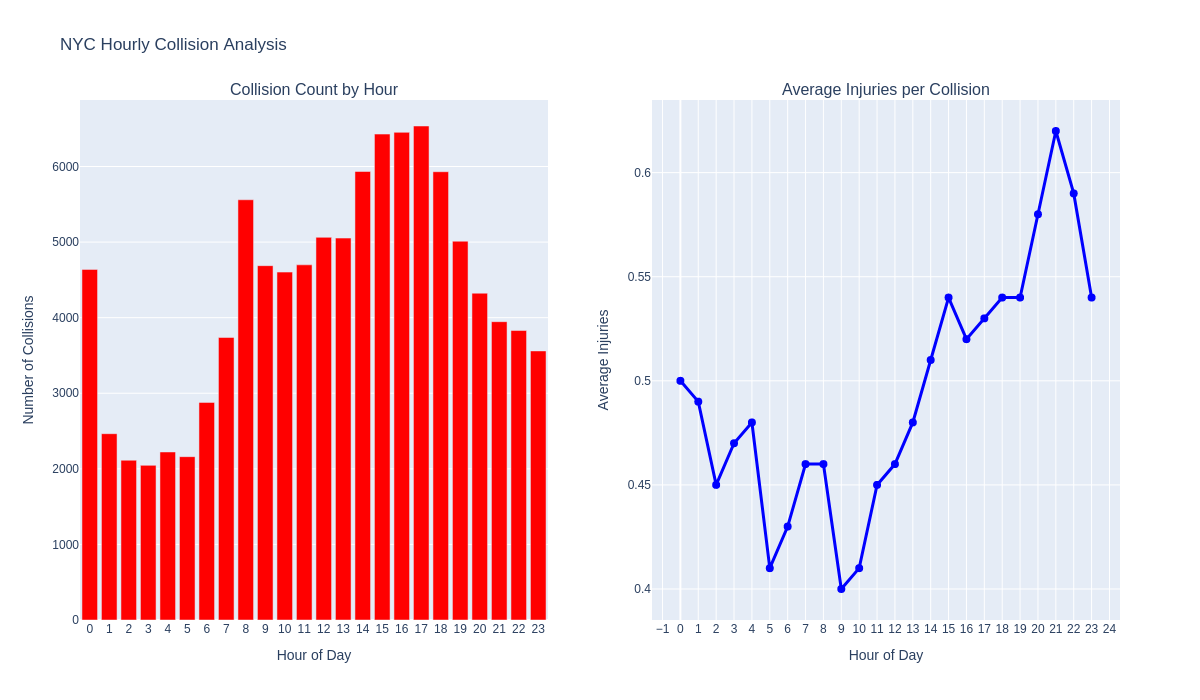

In [12]:
# Then display both the interactive version (for local) and static (for GitHub)
from IPython.display import Image, display
# Interactive for local
display(Image("./static_images/collision_by_hour.png"))  # Static for GitHub

### **Insights**: We can see the most number of accidents have occured during evening, but the average injuries per collision is higher late at night. This means lesser accidents happen late at night but those are more serious

# 2. Analysing collisions by day of week

In [13]:
query = """
select
    strftime(crash_date, '%w') as day_number,
    strftime(crash_date, '%A') as day_of_week,
    count(*) as collision_count,
    round(avg(number_of_persons_injured), 2) as avg_injuries_per_collision
from read_parquet('../output_data/transformed_data.parquet')
where crash_date is not null
group by 1,2
order by 1
"""

daily_df = conn.execute(query).df()

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(
        x=daily_df['day_of_week'],
        y=daily_df['collision_count'],
        name="Number of Collisions",
        marker_color='lightcoral',
        opacity=0.7
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=daily_df['day_of_week'],
        y=daily_df['avg_injuries_per_collision'],
        mode='lines+markers',
        name="Avg Injuries per Collision",
        line=dict(color='darkblue', width=3),
        marker=dict(size=10)
    ),
    secondary_y=True,
)

fig.update_xaxes(title_text="Day of Week")
fig.update_yaxes(title_text="Number of Collisions", secondary_y=False)
fig.update_yaxes(title_text="Average Injuries per Collision", secondary_y=True, range=[0.3, 0.7])

fig.update_layout(
    title="NYC Collisions by Day of Week - Count vs Average Injuries",
    legend=dict(x=0.01, y=0.99),
    height=600
)

fig.show()

In [14]:
fig.write_image(
    "./static_images/collision_by_day_of_week.png",
    width=1200,
    height=700,
    scale=1
)

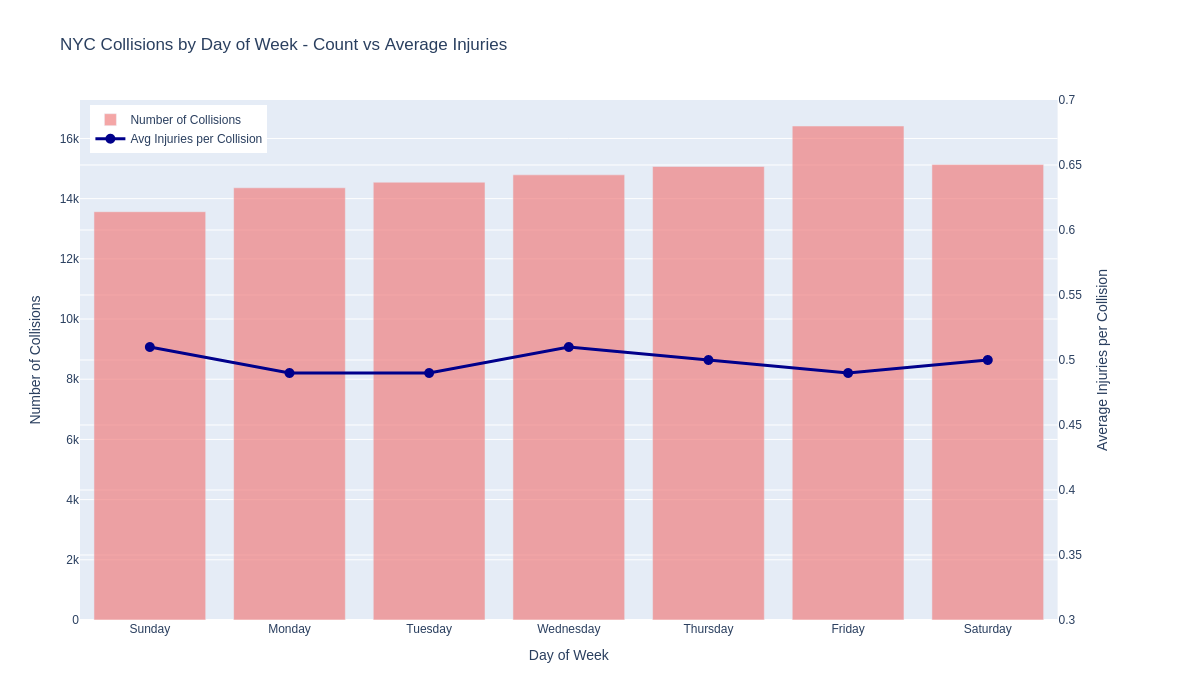

In [16]:
# Then display both the interactive version (for local) and static (for GitHub)
from IPython.display import Image, display
# Interactive for local
display(Image("./static_images/collision_by_day_of_week.png"))  # Static for GitHub

### **Insights** : We can see the number of accidents are comparable among all the days, but if we dig deeper we can see the number of accidents on weekends are lower and it starts going up as the week progresses. The average injuries per collision stays within a similar range, meaning we can't differentiate the accidents happening on different days much, on the basis of seriousness of the accidents

# 3. Analysing collisions by month

In [17]:
query = """
select
    extract(month from crash_date) as month_number,
    strftime(crash_date, '%B') as month_name,
    count(*) as collision_count,
    sum(number_of_persons_injured) as total_injuries,
    round(avg(number_of_persons_injured), 2) as avg_injuries_per_collision
from read_parquet('../output_data/transformed_data.parquet')
where crash_date is not null
group by 1,2
order by 1
"""

monthly_df = conn.execute(query).df()

# Create dual y-axis chart
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add collision count as bars
fig.add_trace(
    go.Bar(
        x=monthly_df['month_name'],
        y=monthly_df['collision_count'],
        name="Number of Collisions",
        marker_color='lightcoral',
        opacity=0.7
    ),
    secondary_y=False,
)

# Add average injuries as line
fig.add_trace(
    go.Scatter(
        x=monthly_df['month_name'],
        y=monthly_df['avg_injuries_per_collision'],
        mode='lines+markers',
        name="Avg Injuries per Collision",
        line=dict(color='darkblue', width=3),
        marker=dict(size=10)
    ),
    secondary_y=True,
)

# Update layout
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Number of Collisions", secondary_y=False)
fig.update_yaxes(
    title_text="Average Injuries per Collision",
    secondary_y=True,
    range=[0.3, 0.7]
)

fig.update_layout(
    title="NYC Collisions by Month - Count vs Average Injuries",
    legend=dict(x=0.01, y=0.99),
    height=600
)

fig.show()

In [18]:
fig.write_image(
    "./static_images/collision_by_month.png",
    width=1200,
    height=700,
    scale=1
)

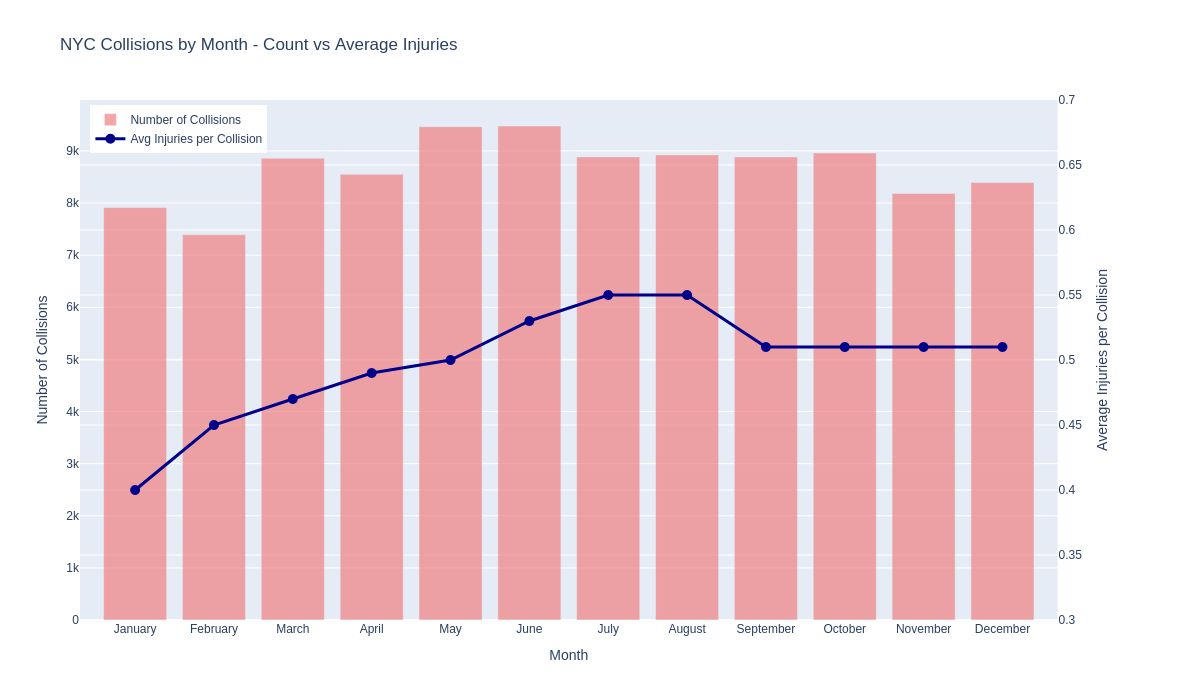

In [19]:
# Then display both the interactive version (for local) and static (for GitHub)
from IPython.display import Image, display
# Interactive for local
display(Image("./static_images/collision_by_month.png"))  # Static for GitHub

### **Insights** : We can see from the graph that both the number of accidents and seriousness of accidents peak during the summer. These metrics keep going higher from the starting of year and eventually plateau from the onset of fall season.

# 4. Analysing collision on holiday vs non-holiday

In [20]:
query = """
select
    case
        when is_holiday = true then 'Holiday'
        else 'Non-Holiday'
    end as day_type,
    count(*) as total_collisions,
    count(distinct crash_date) as unique_days,
    round(cast(count(*) as float) / count(distinct crash_date), 1) as avg_collisions_per_day
from read_parquet('../output_data/transformed_data.parquet')
where crash_date is not null
group by 1
order by 1
"""

holiday_df = conn.execute(query).df()

fig = px.bar(holiday_df,
             x='day_type',
             y='avg_collisions_per_day',
             title='Average Collisions per Day: Holiday vs Non-Holiday',
             labels={'day_type': 'Day Type', 'avg_collisions_per_day': 'Average Collisions per Day'},
             color='day_type',
             color_discrete_map={'Holiday': 'red', 'Non-Holiday': 'blue'},
             text=[f"{x:.1f}" for x in holiday_df['avg_collisions_per_day']])

fig.update_traces(
    textposition='outside',
    width=0.4
)

fig.update_layout(
    xaxis_title="Day Type",
    yaxis_title="Average Collisions per Day",
    width=500,
    height=500,
    showlegend=False,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.show()

In [21]:
fig.write_image(
    "./static_images/collision_by_holiday.png",
    width=1200,
    height=700,
    scale=1
)

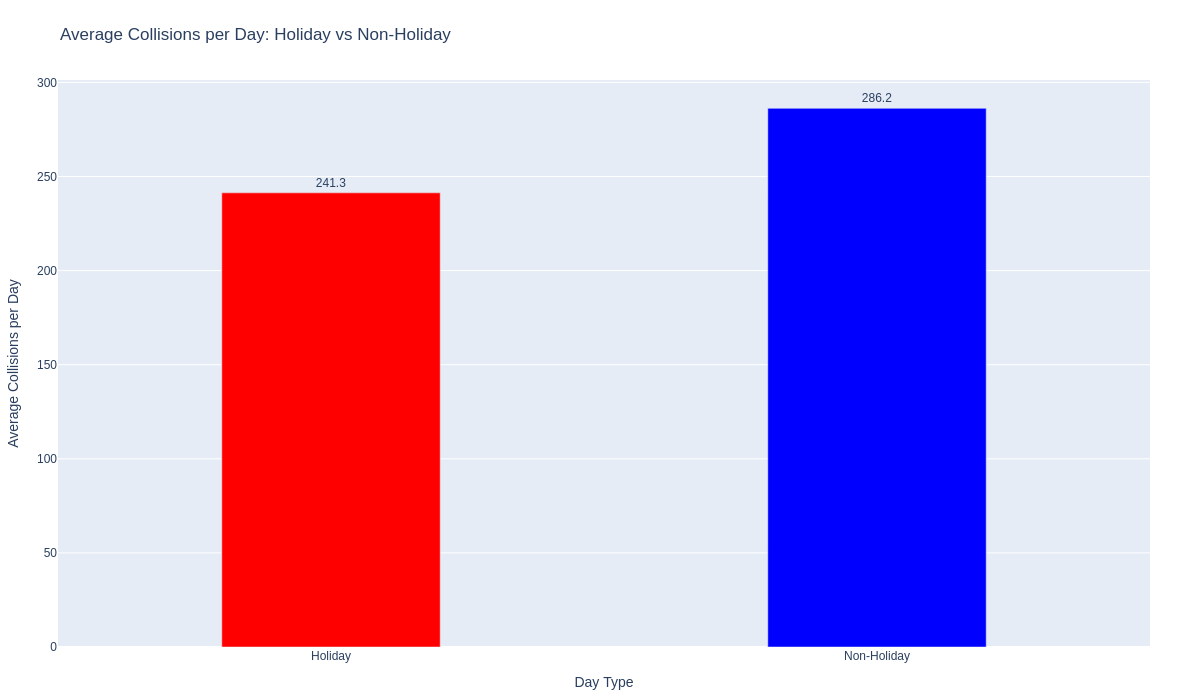

In [22]:
# Then display both the interactive version (for local) and static (for GitHub)
from IPython.display import Image, display
# Interactive for local
display(Image("./static_images/collision/collision_by_holiday.png"))  # Static for GitHub

### **Insights** : We can see that the average number of collisions per day on holidays is lower than on non-holidays for the year **2022**